In [ ]:
import gym, os
from itertools import count
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = gym.make("CartPole-v0").unwrapped
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
lr = 0.0001

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
class Actor(nn.Module):
    def __init__(self, state_size, action_size):
        super(Actor, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.linear1 = nn.Linear(self.state_size, 128)
        self.linear2 = nn.Linear(128, 256)
        self.linear3 = nn.Linear(256, self.action_size)

    def forward(self, state):
        output = F.relu(self.linear1(state))
        output = F.relu(self.linear2(output))
        output = self.linear3(output)
        distribution = Categorical(F.softmax(output, dim=-1))
        return distribution


class Critic(nn.Module):
    def __init__(self, state_size, action_size):
        super(Critic, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.linear1 = nn.Linear(self.state_size, 128)
        self.linear2 = nn.Linear(128, 256)
        self.linear3 = nn.Linear(256, 1)

    def forward(self, state):
        output = F.relu(self.linear1(state))
        output = F.relu(self.linear2(output))
        value = self.linear3(output)
        return value

In [ ]:
# Plot duration curve:
# From http://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
episode_durations = []
def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.FloatTensor(episode_durations)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated

In [ ]:
def compute_returns(next_value, rewards, masks, gamma=0.99):
    R = next_value
    returns = []
    for step in reversed(range(len(rewards))):
        R = rewards[step] + gamma * R * masks[step]
        returns.insert(0, R)
    return returns

In [ ]:

def trainIters(actor, critic, n_iters):
    optimizerA = optim.Adam(actor.parameters())
    optimizerC = optim.Adam(critic.parameters())
    for iter in range(n_iters):
        state = env.reset()
        log_probs = []
        values = []
        rewards = []
        masks = []
        entropy = 0
        env.reset()

        for i in count():
            #env.render()
            state = torch.FloatTensor(state).to(device)
            dist, value = actor(state), critic(state)
            action = dist.sample()
            next_state, reward, done, _,a = env.step(action.cpu().numpy())

            log_prob = dist.log_prob(action).unsqueeze(0)
            entropy += dist.entropy().mean()

            log_probs.append(log_prob)
            values.append(value)
            rewards.append(torch.tensor([reward], dtype=torch.float, device=device))
            masks.append(torch.tensor([1-done], dtype=torch.float, device=device))

            state = next_state

            if done:
                #print('Iteration: {}, Score: {}'.format(iter, i))
                episode_durations.append(i + 1)
                plot_durations()
                break

        next_state = torch.FloatTensor(next_state).to(device)
        next_value = critic(next_state)
        returns = compute_returns(next_value, rewards, masks)
        log_probs = torch.cat(log_probs)
        returns = torch.cat(returns).detach()
        values = torch.cat(values)

        advantage = returns - values

        actor_loss = -(log_probs * advantage.detach()).mean()
        critic_loss = advantage.pow(2).mean()

        optimizerA.zero_grad()
        optimizerC.zero_grad()
        actor_loss.backward()
        critic_loss.backward()
        optimizerA.step()
        optimizerC.step()
    #env.close()

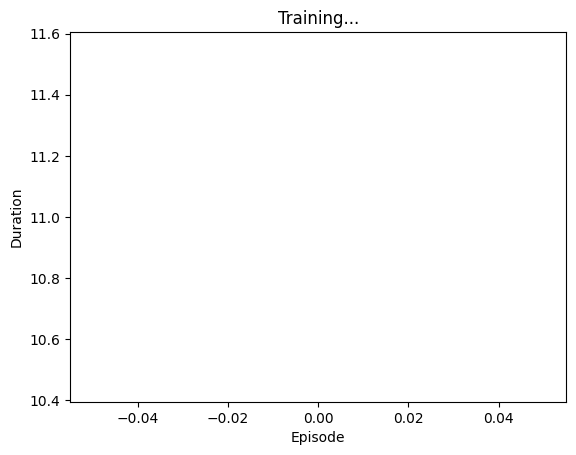

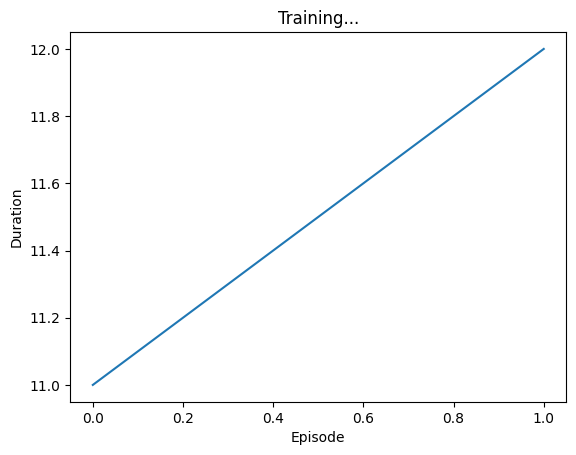

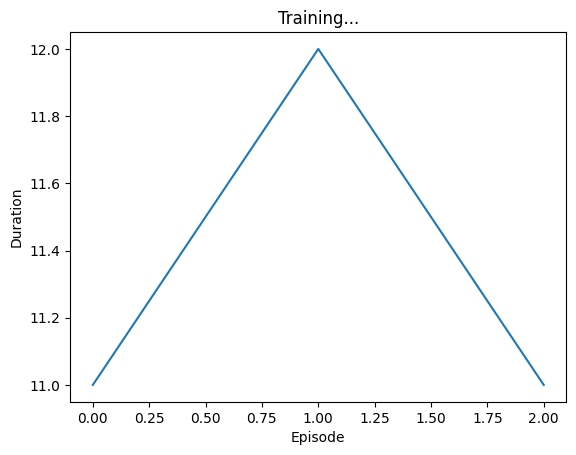

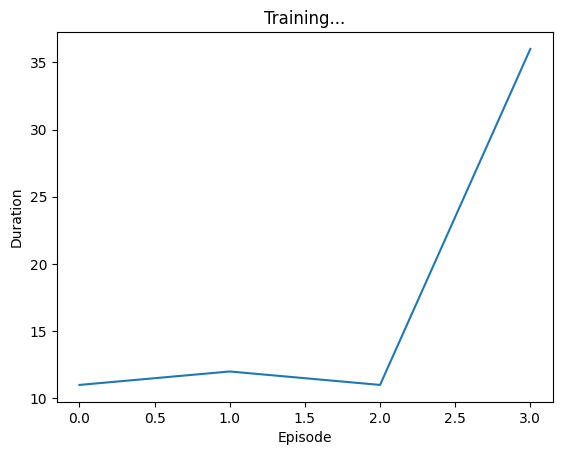

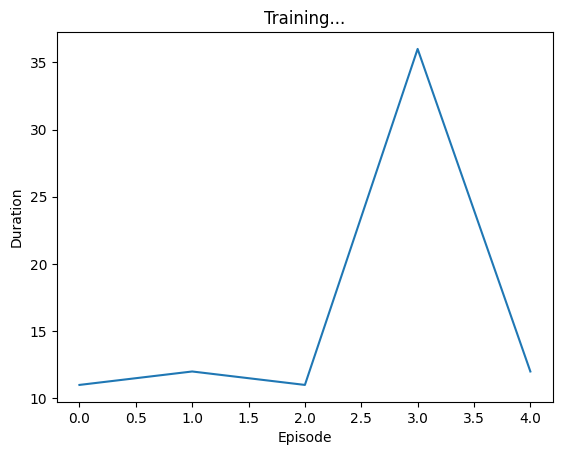

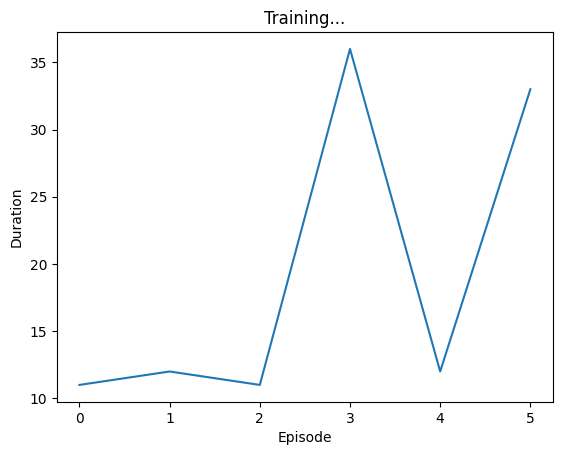

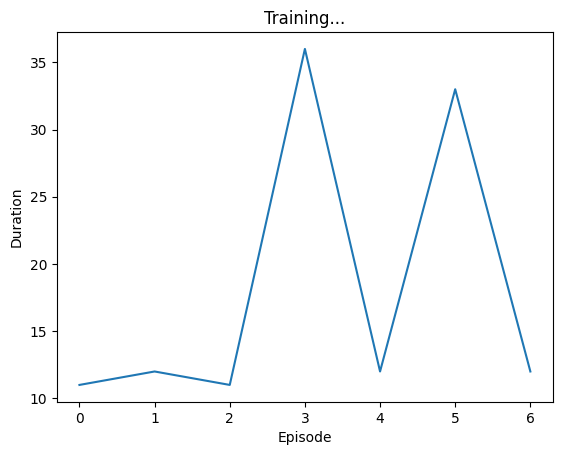

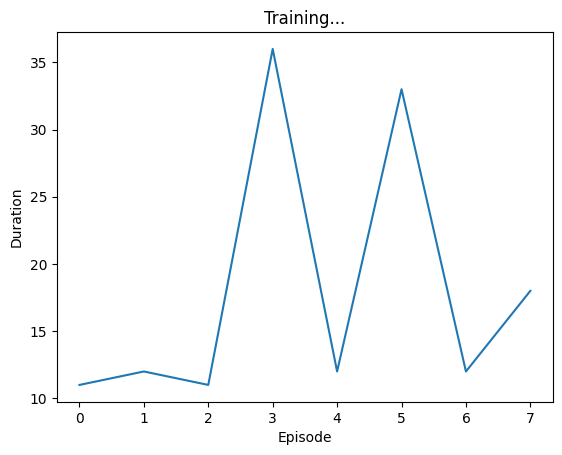

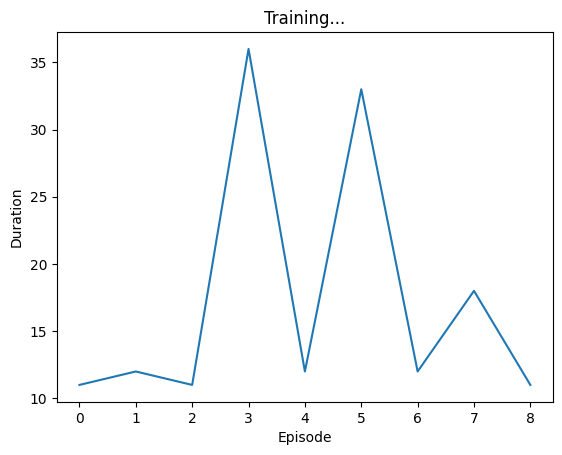

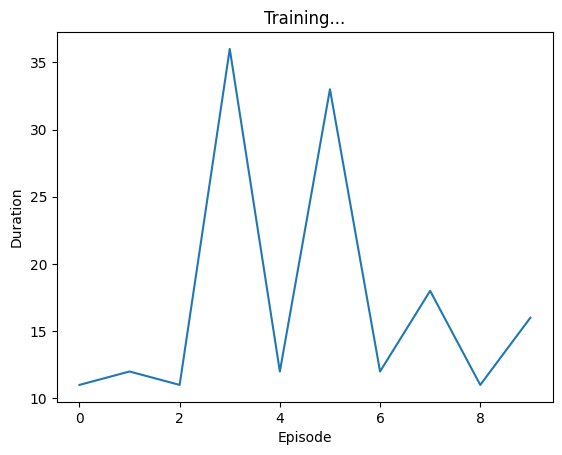

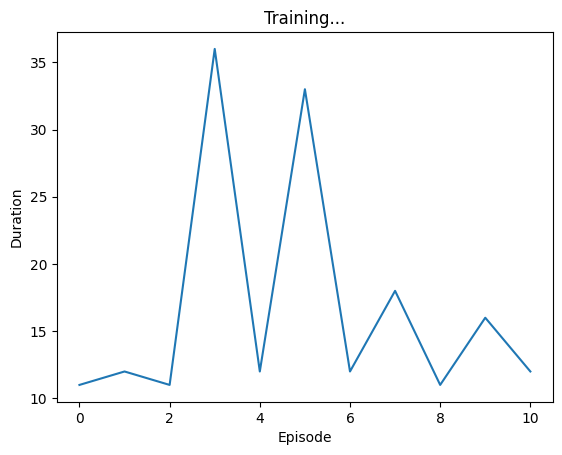

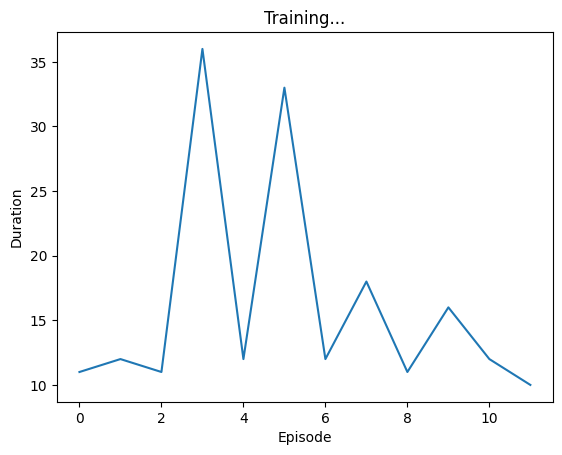

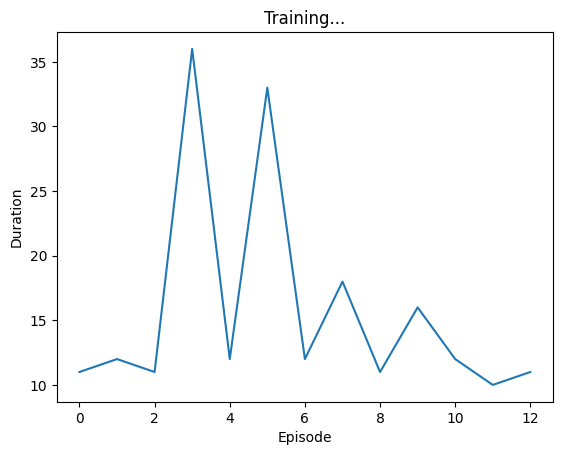

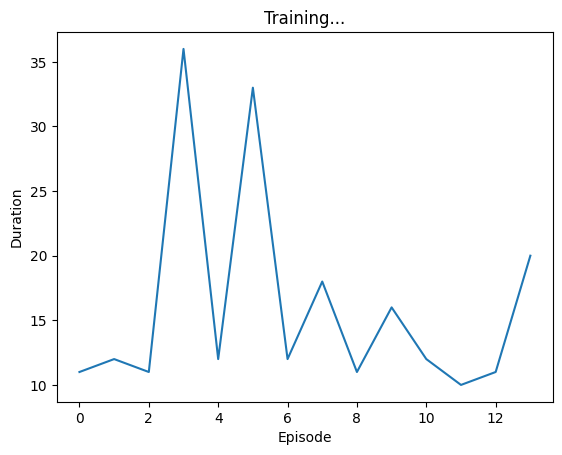

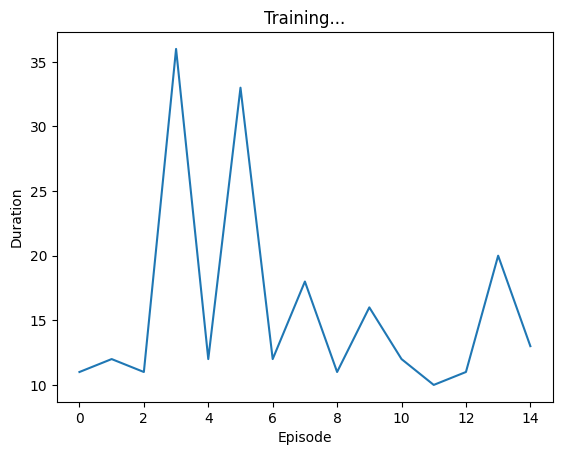

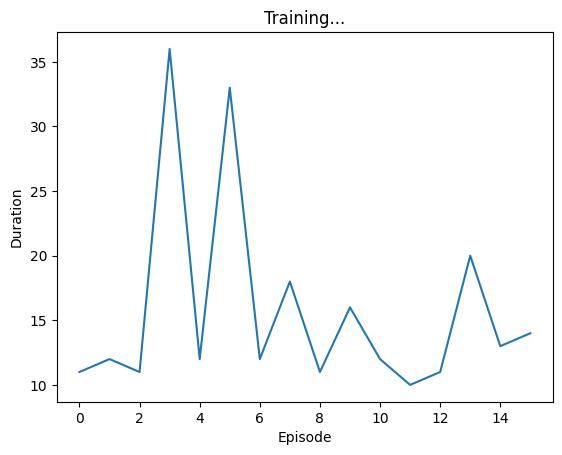

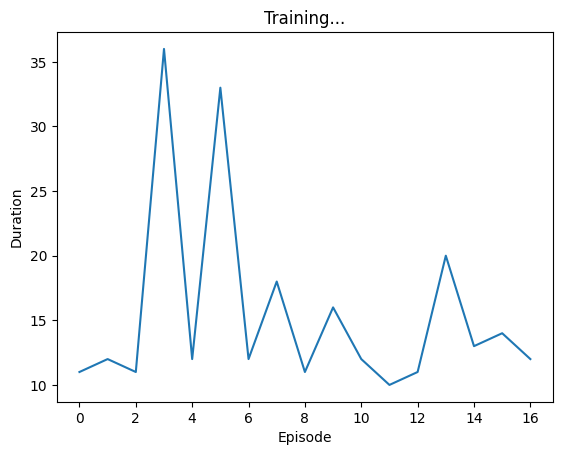

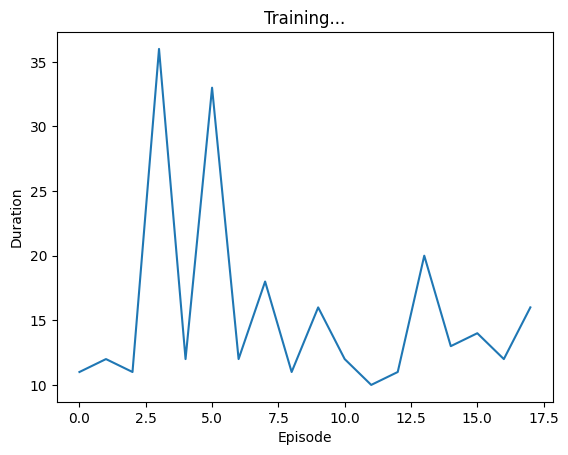

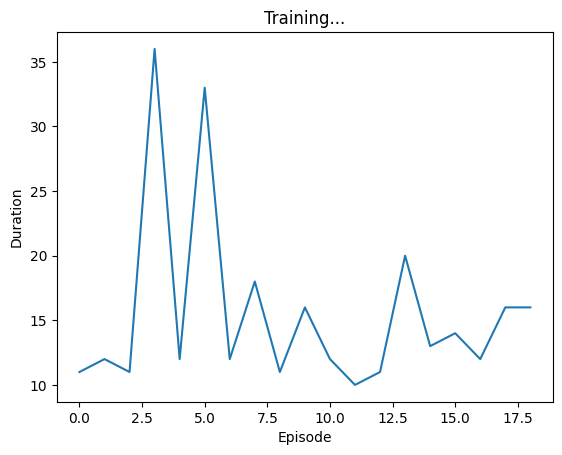

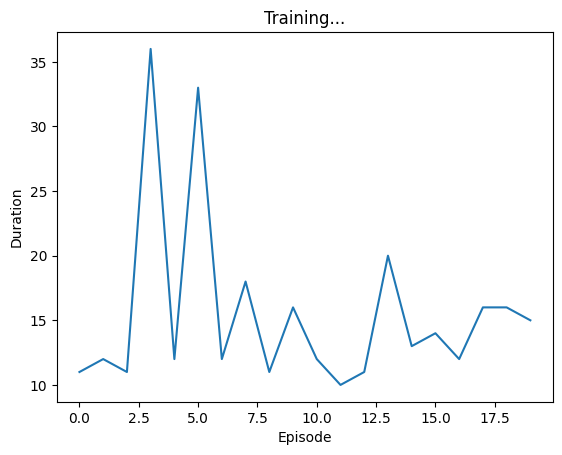

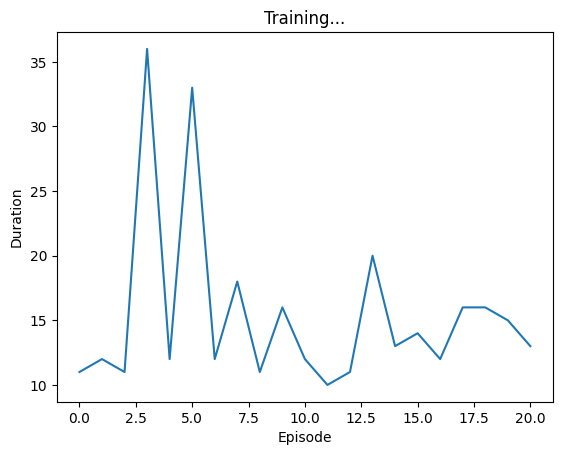

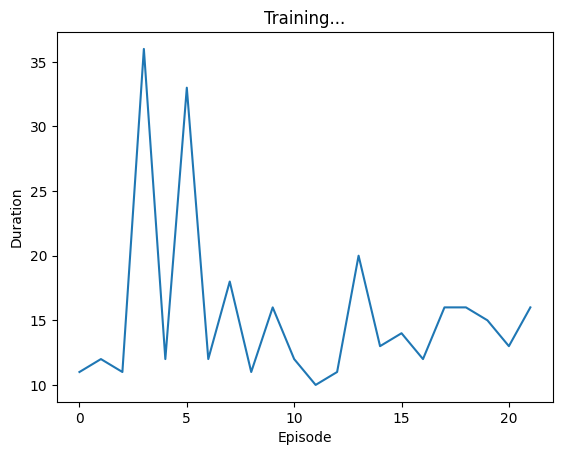

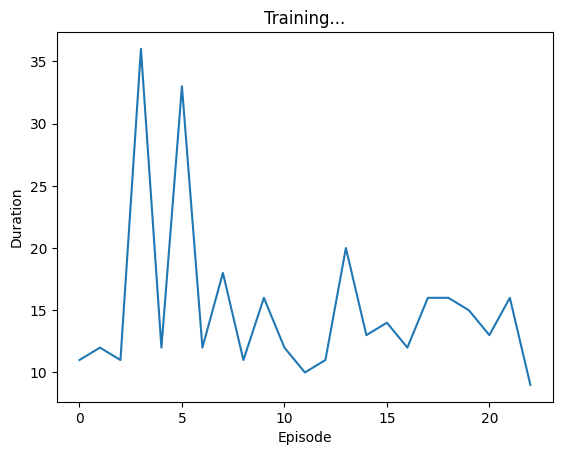

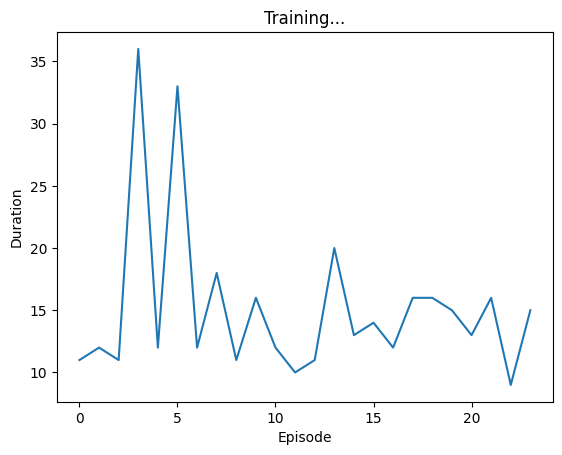

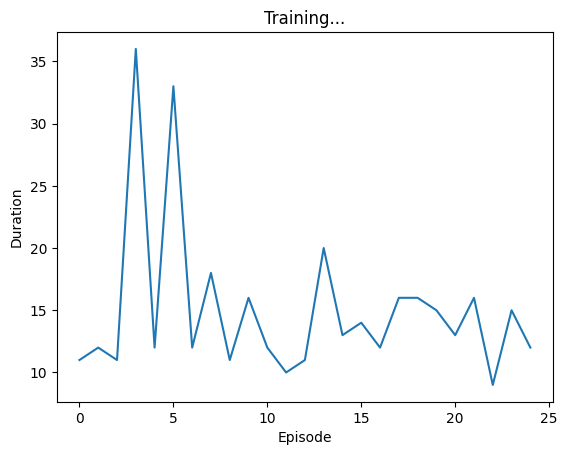

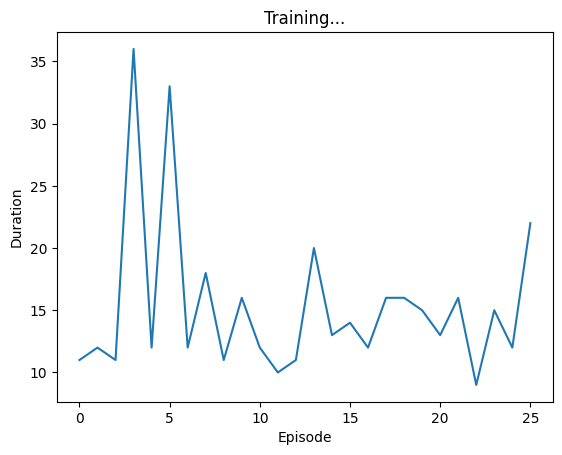

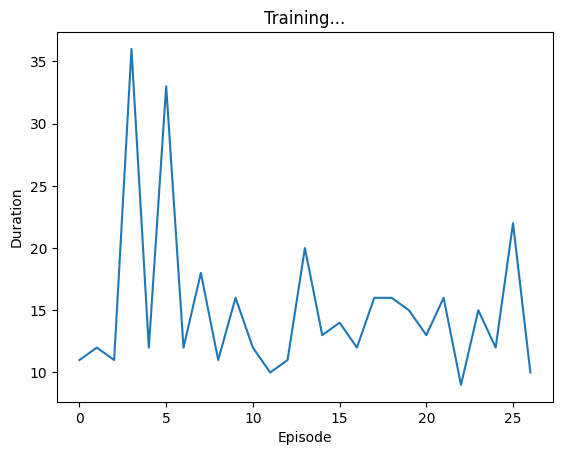

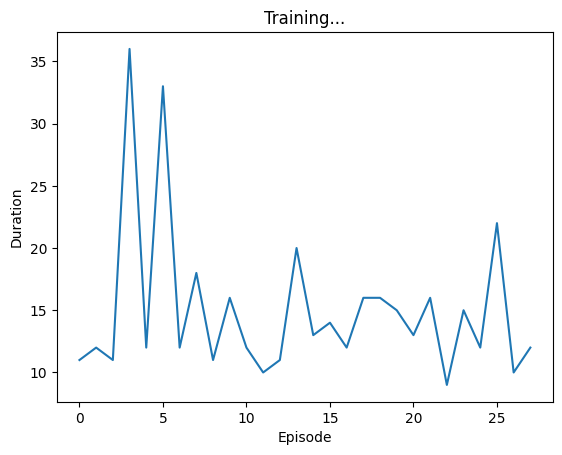

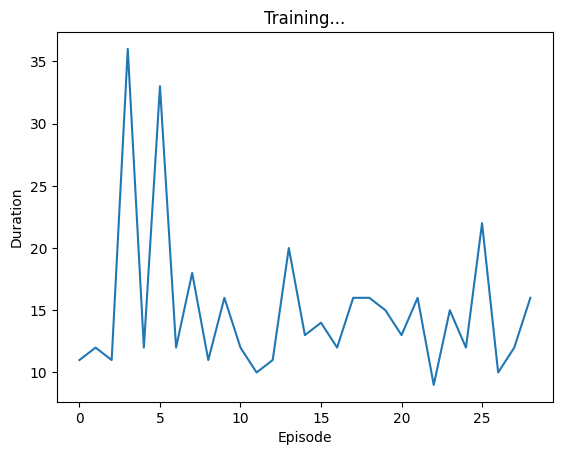

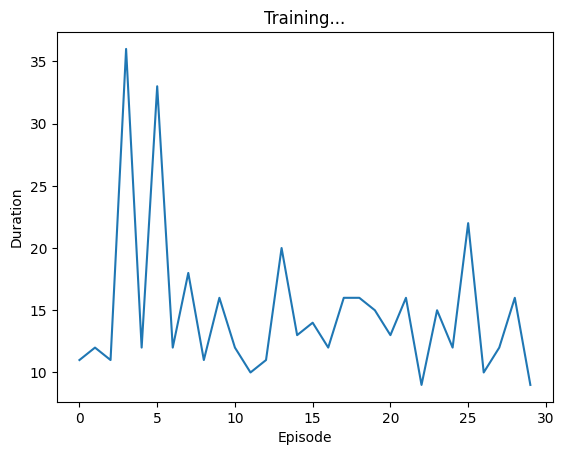

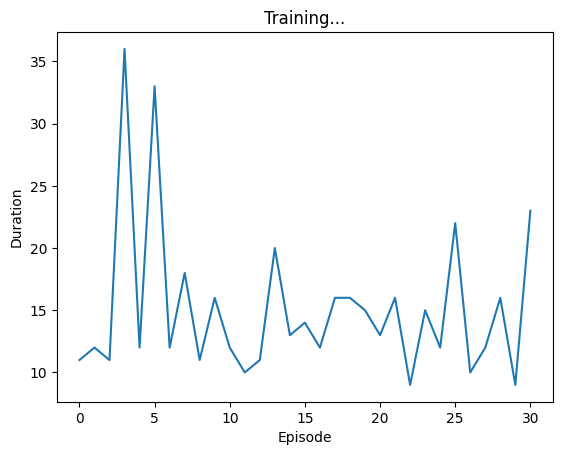

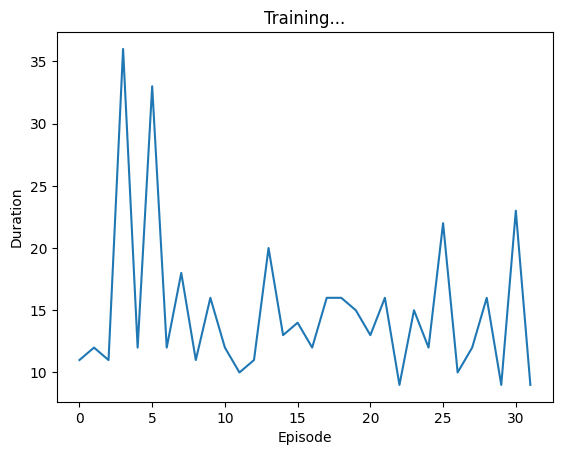

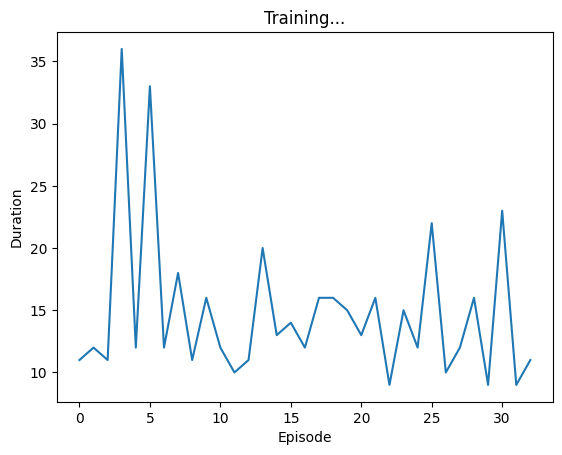

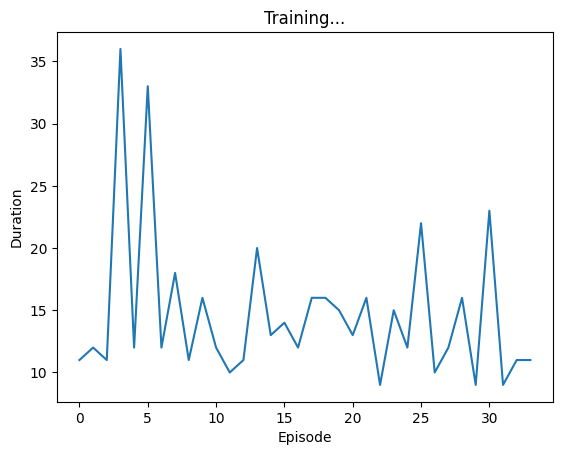

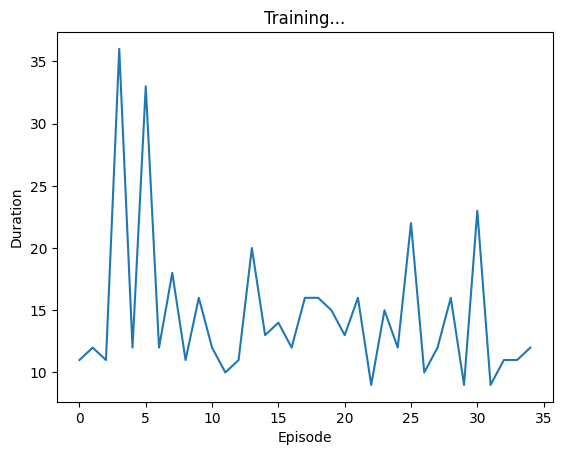

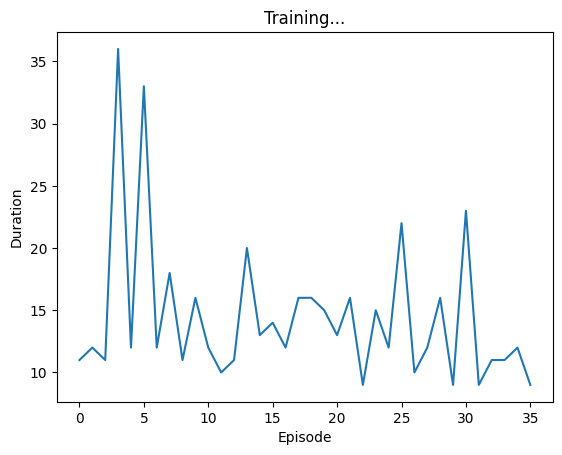

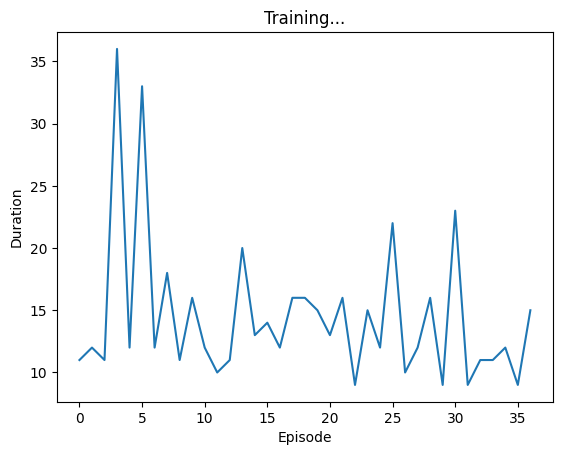

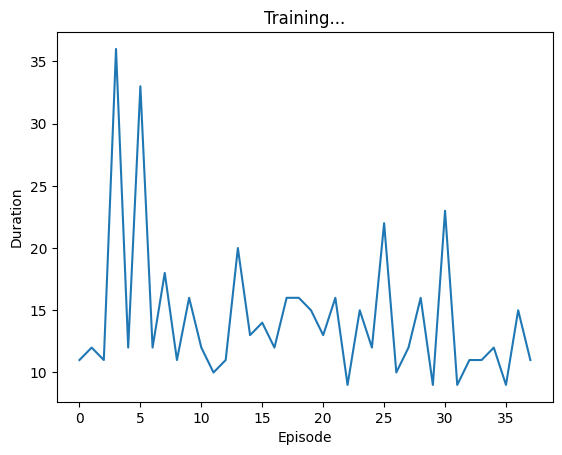

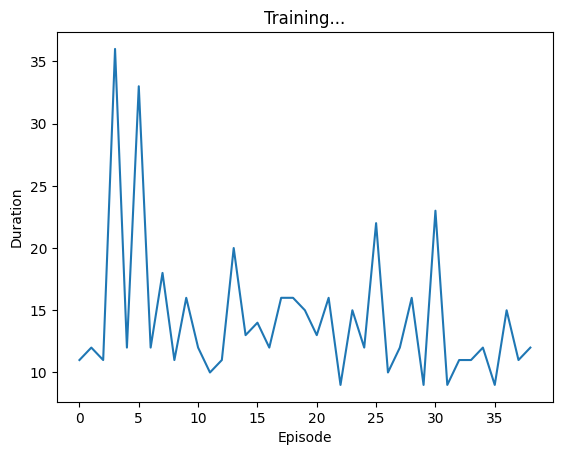

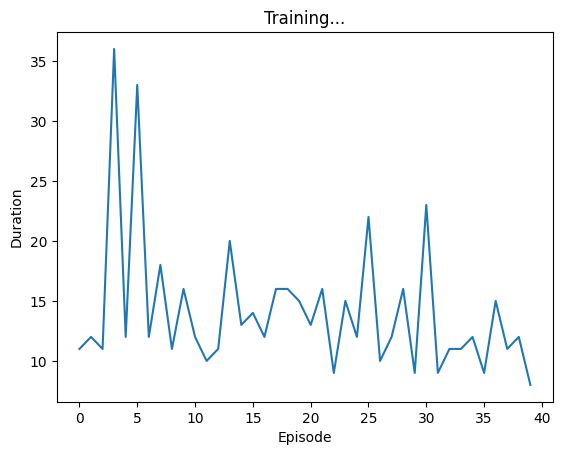

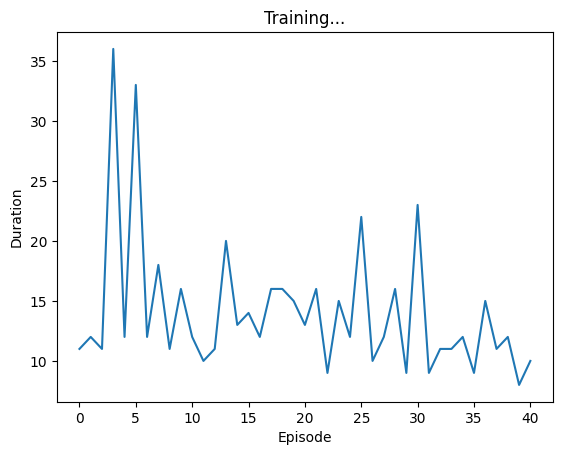

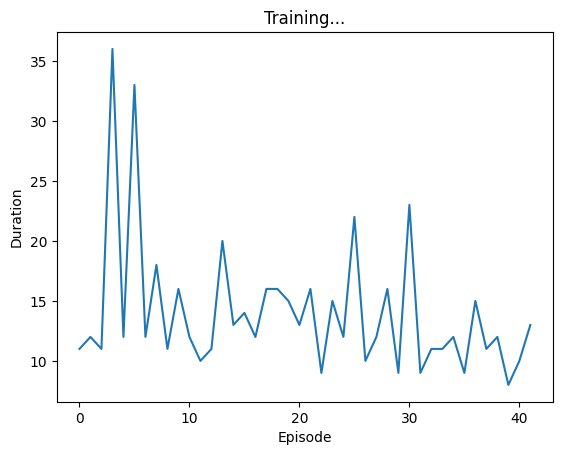

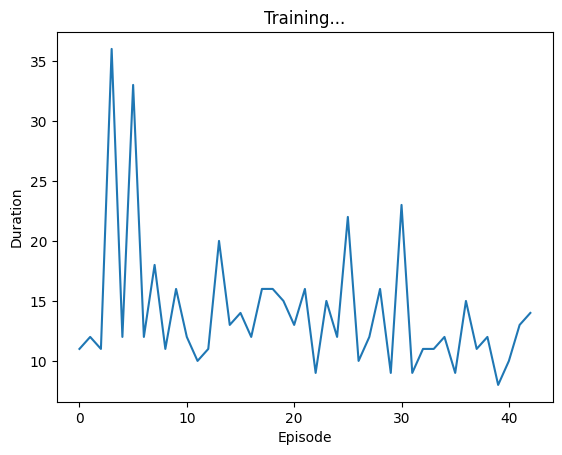

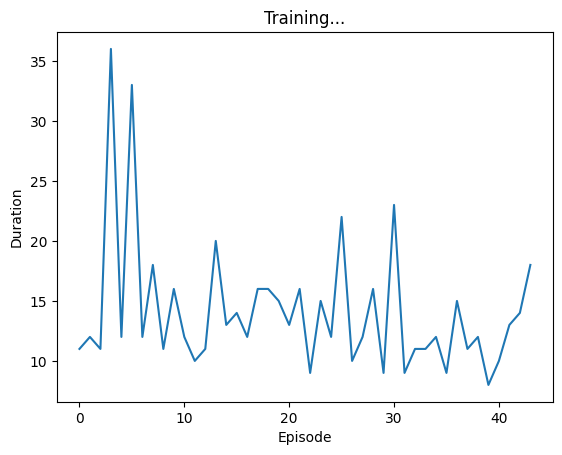

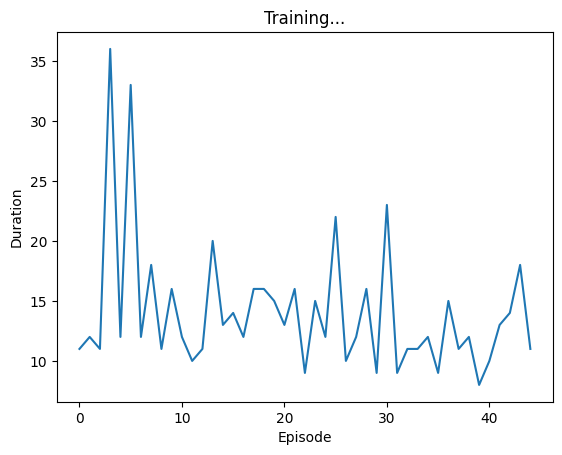

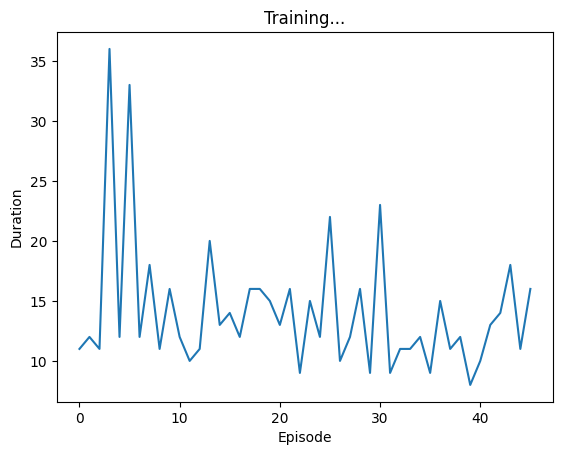

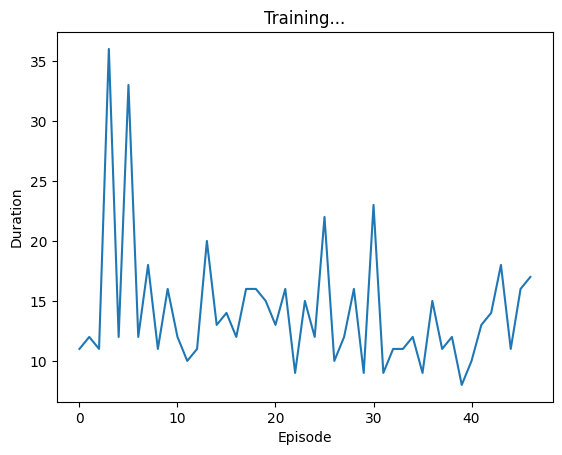

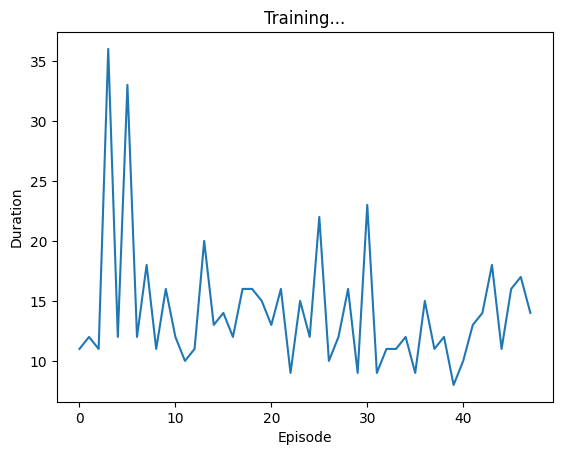

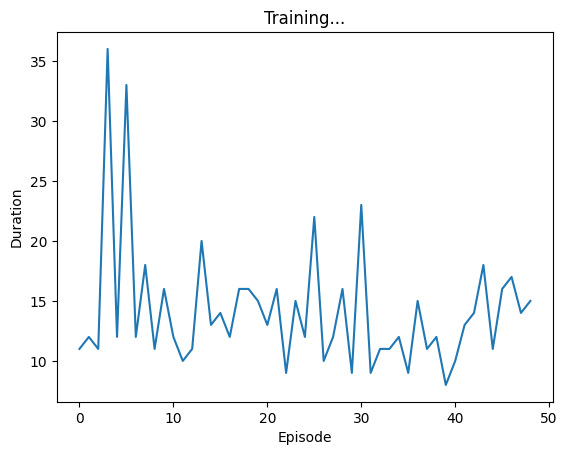

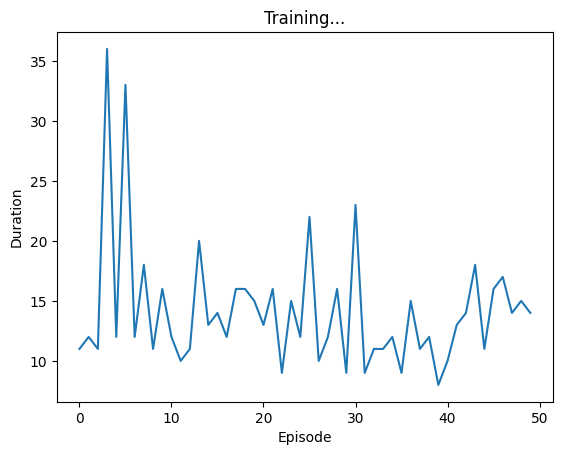

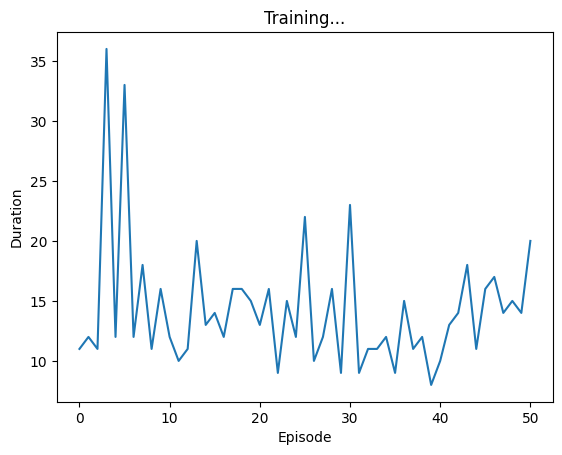

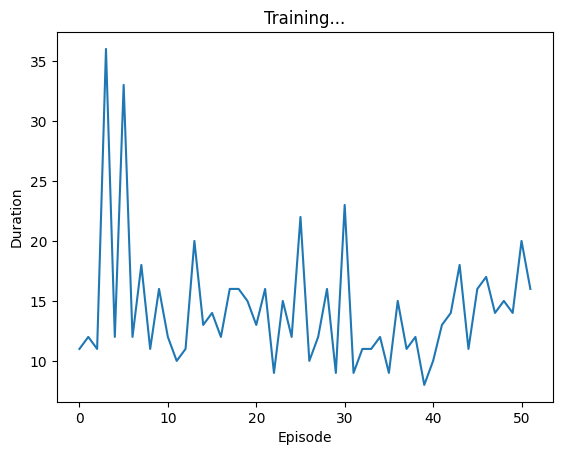

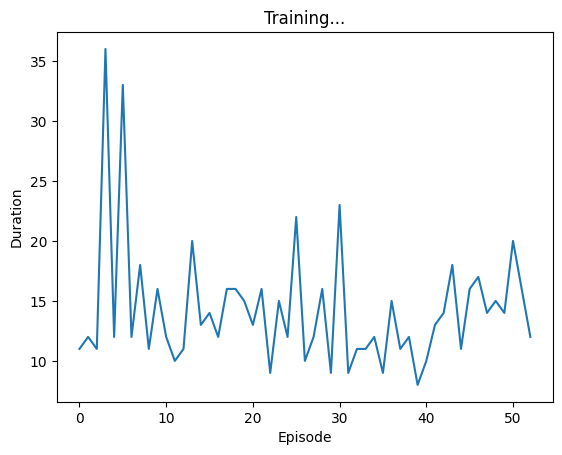

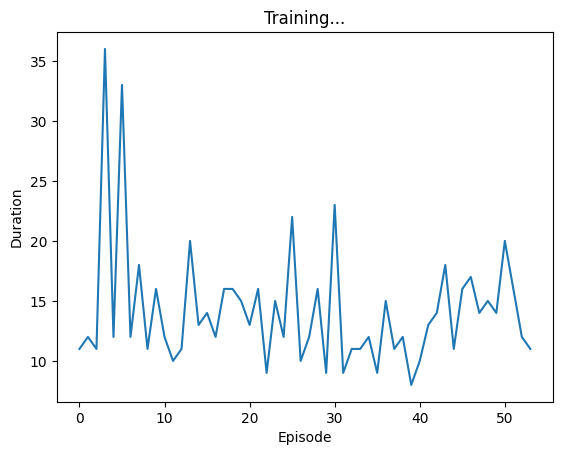

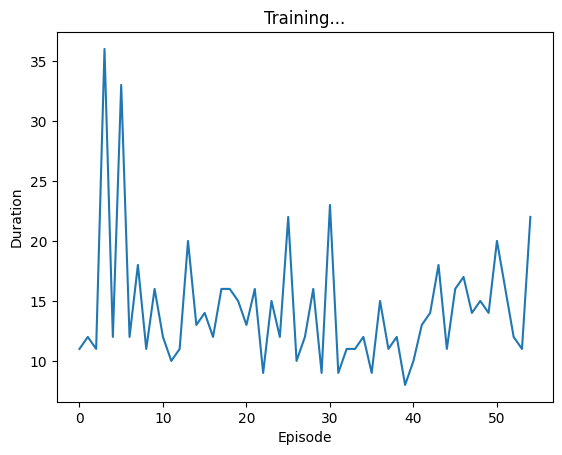

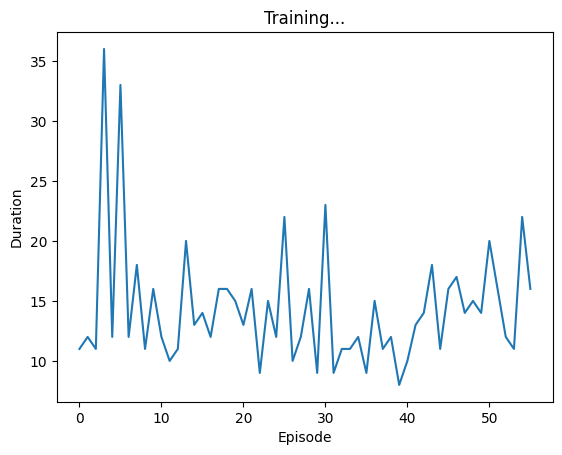

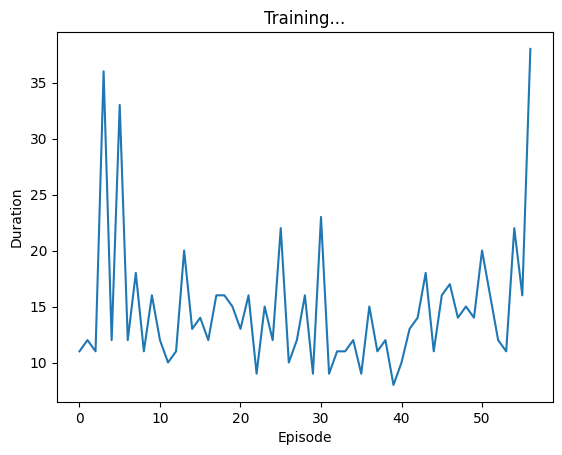

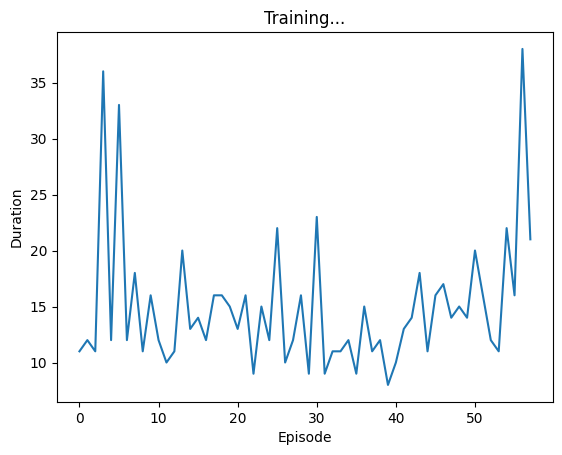

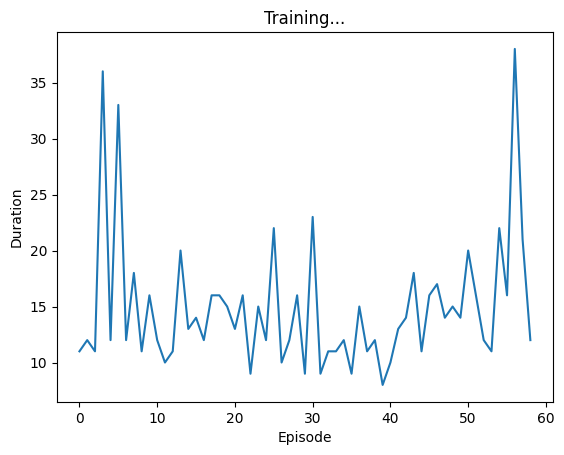

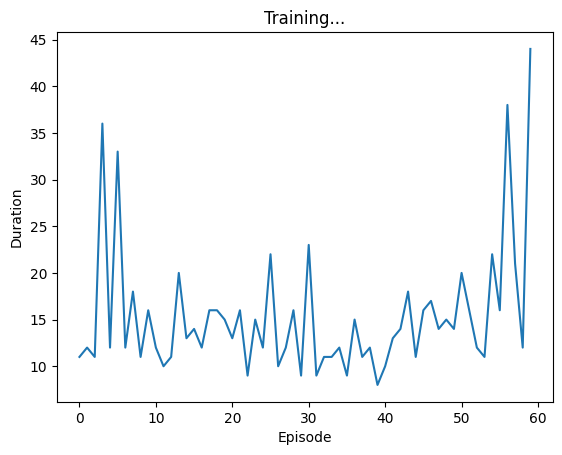

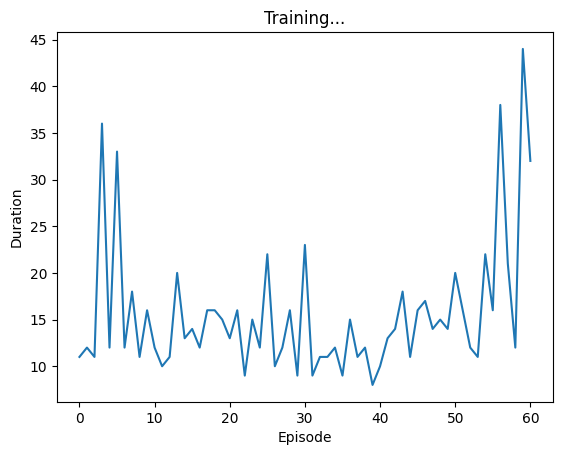

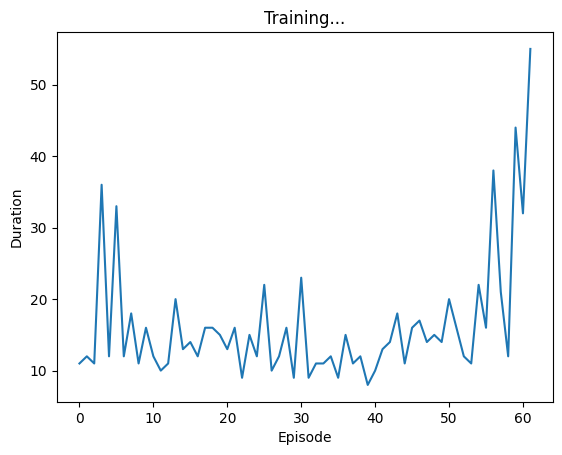

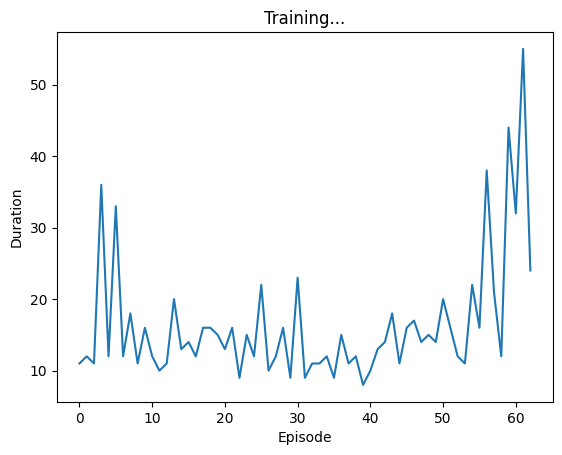

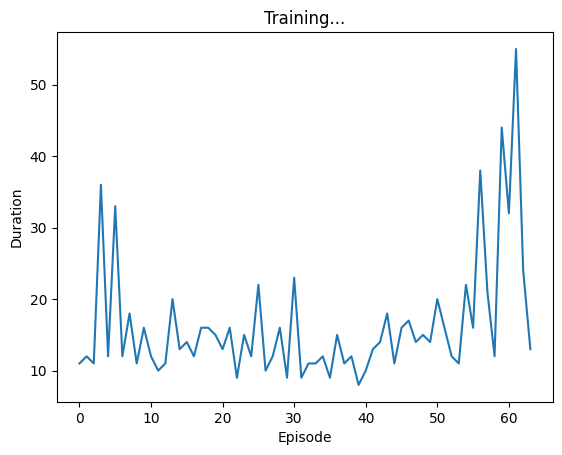

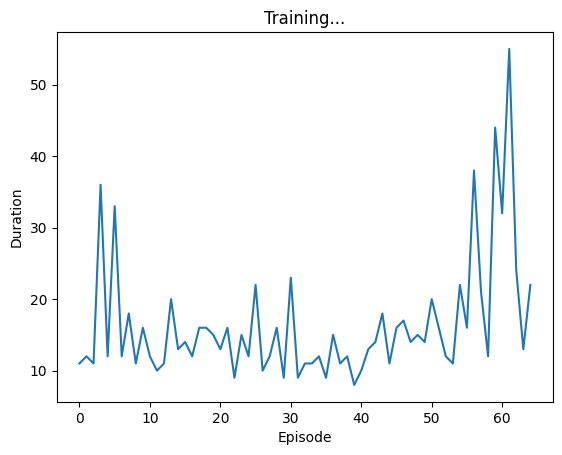

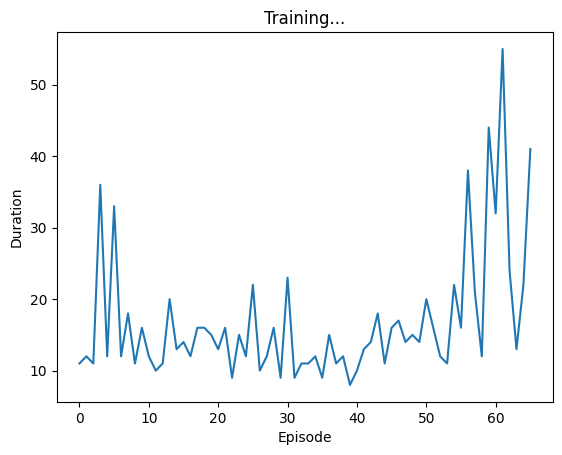

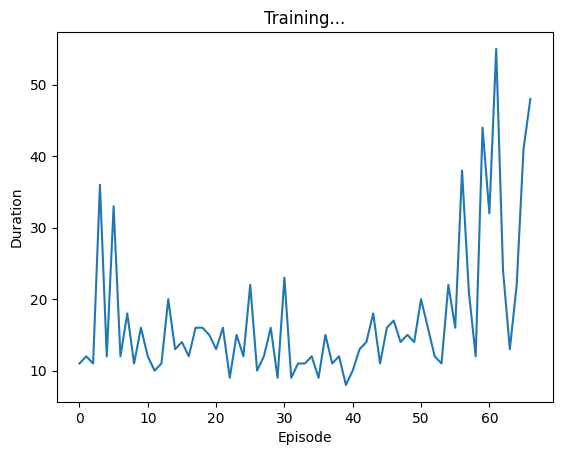

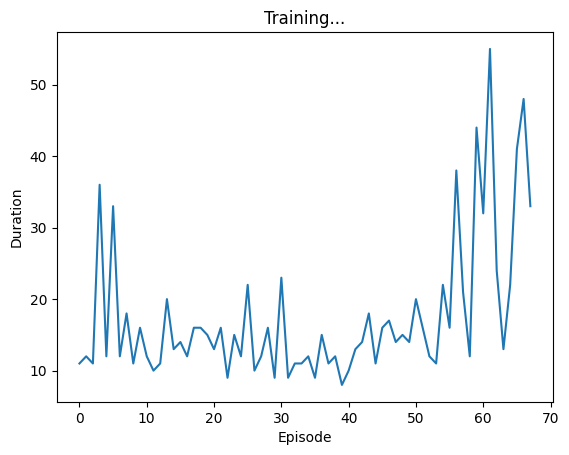

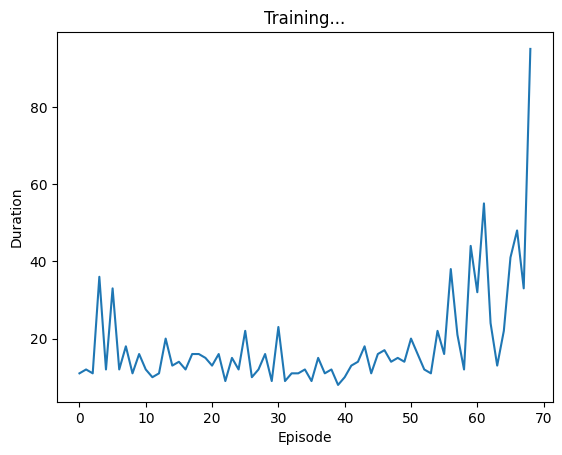

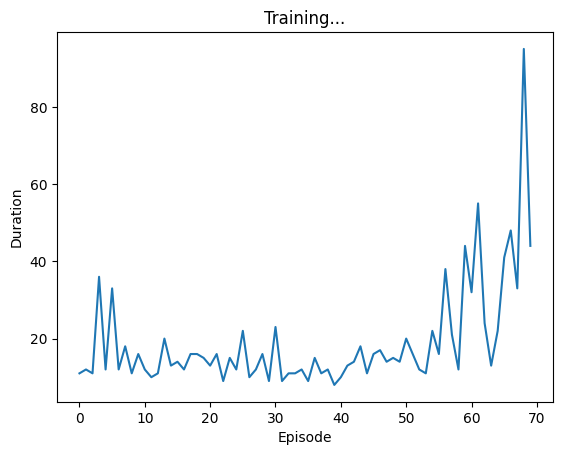

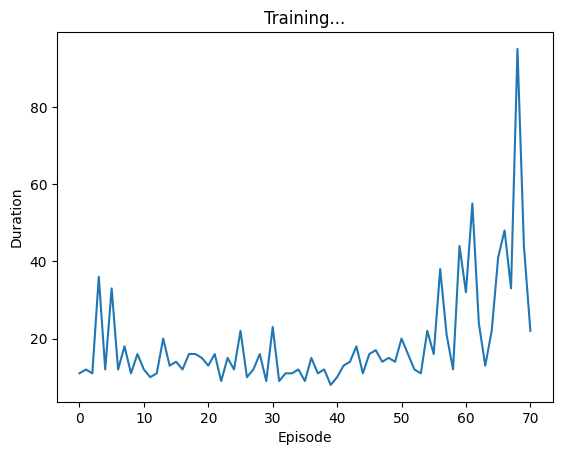

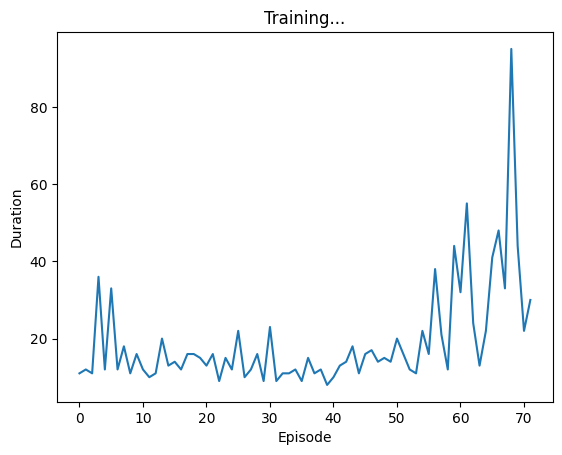

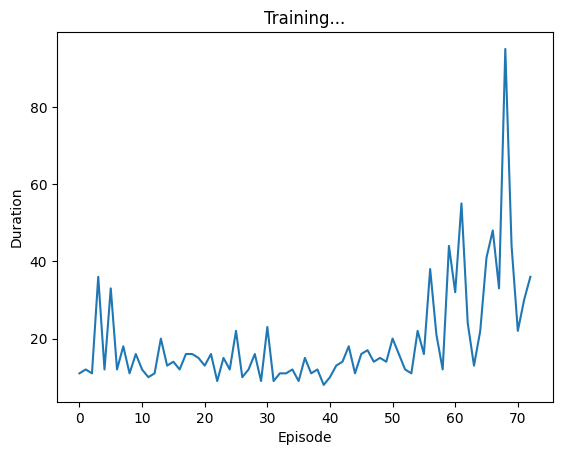

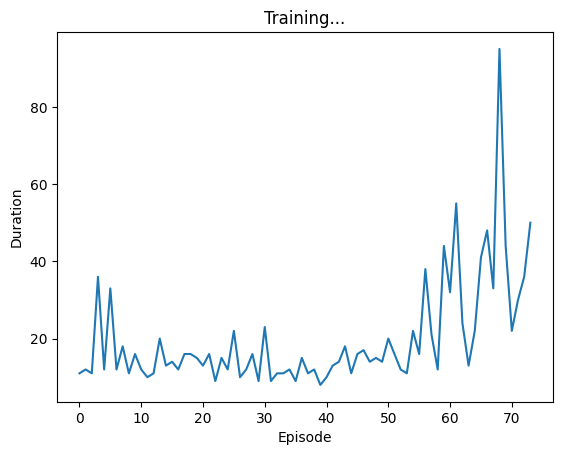

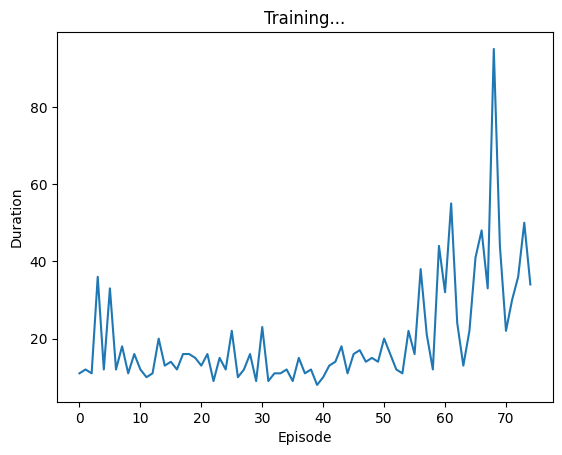

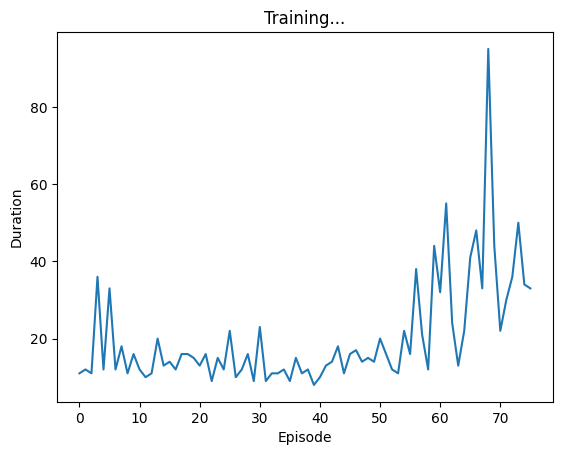

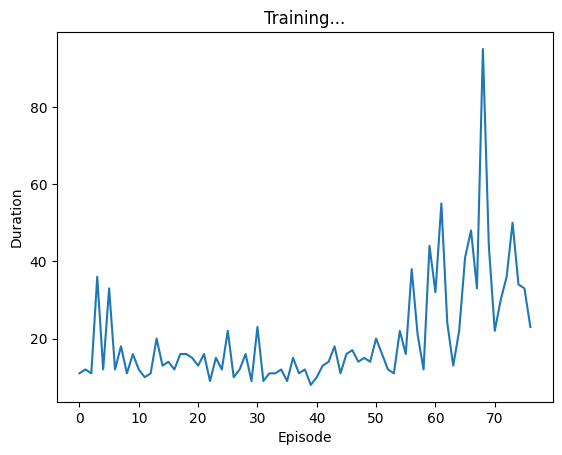

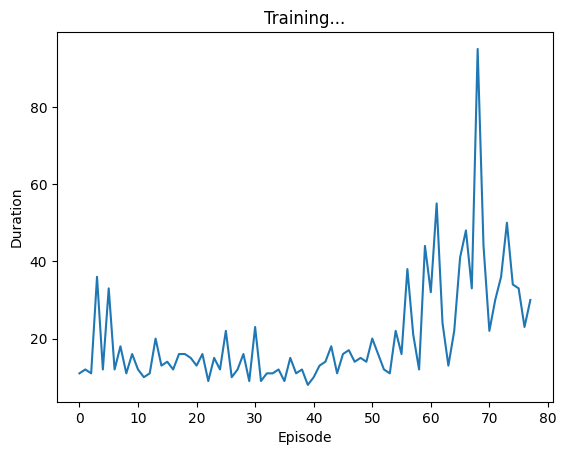

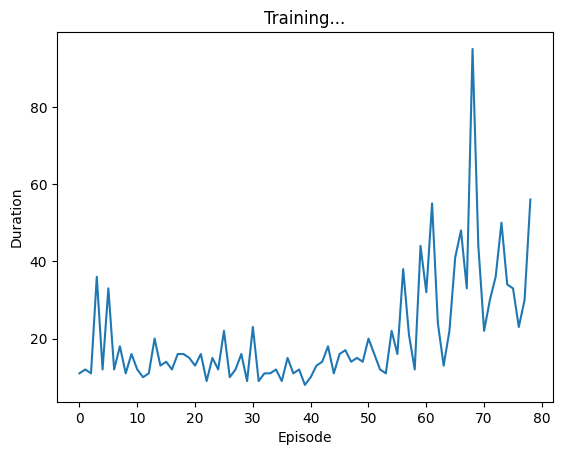

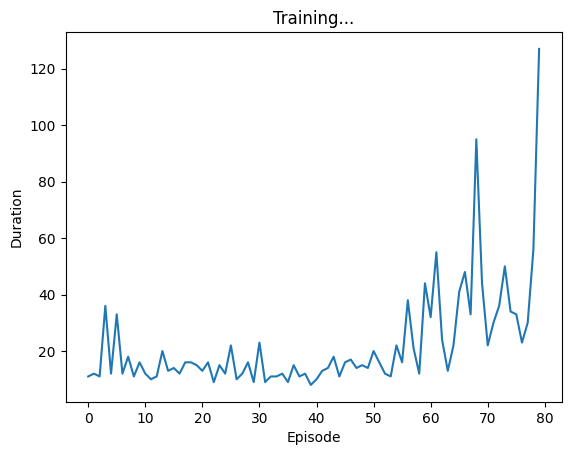

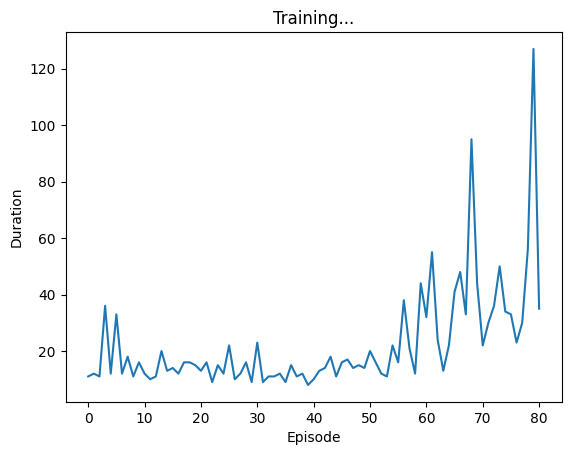

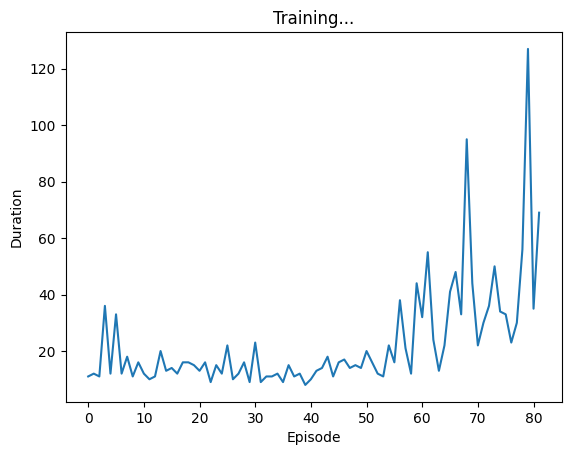

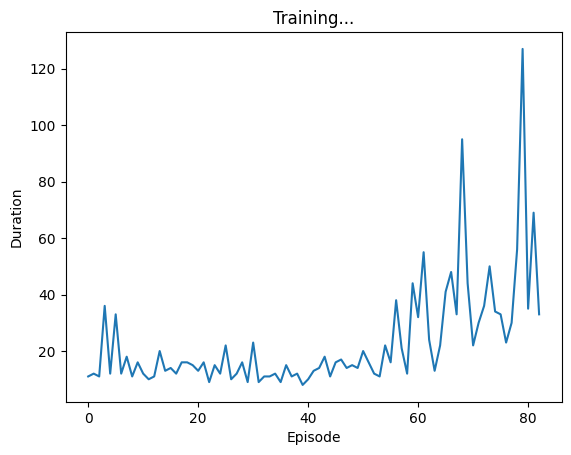

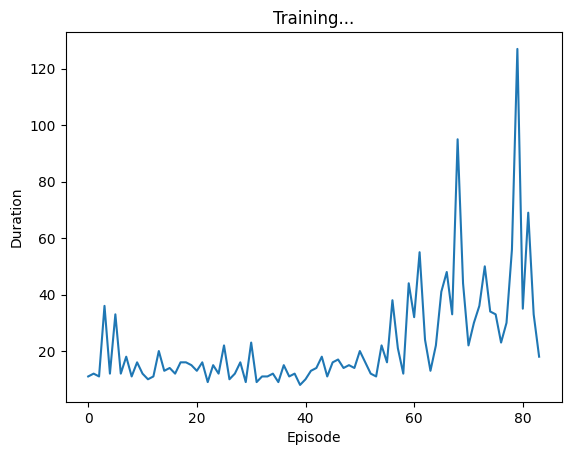

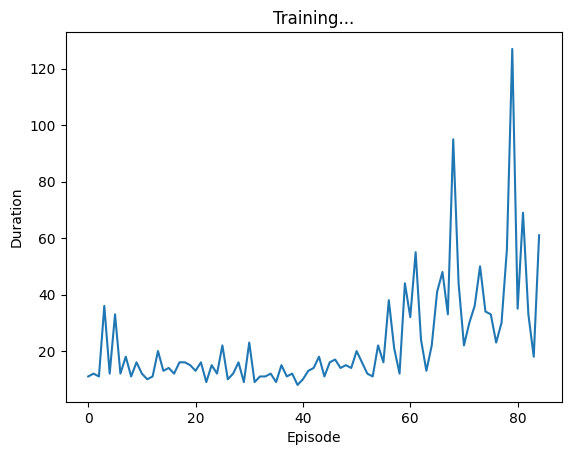

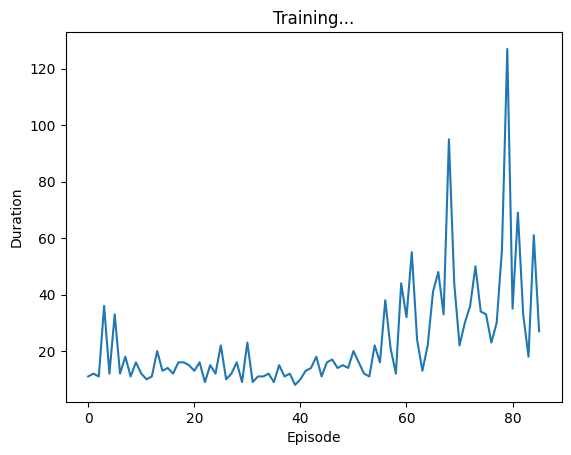

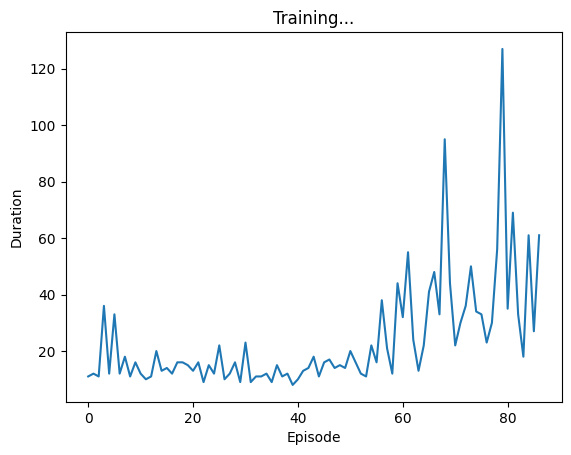

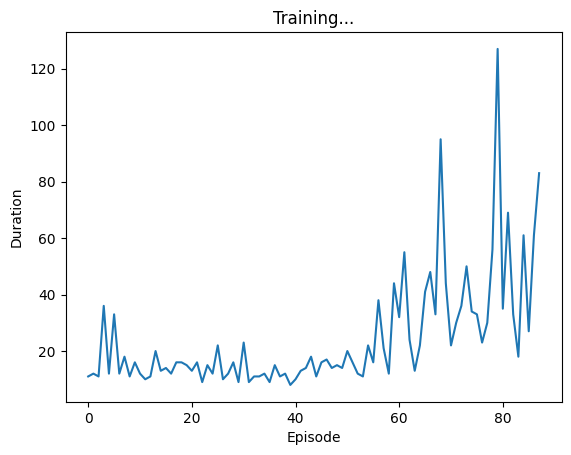

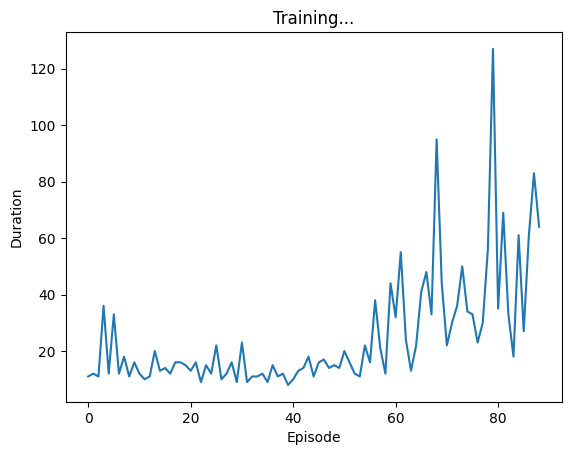

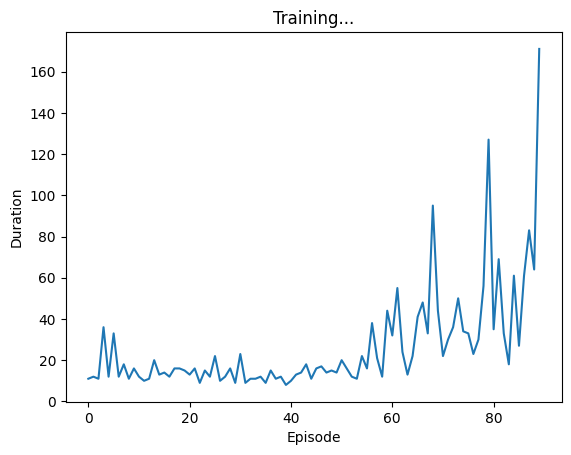

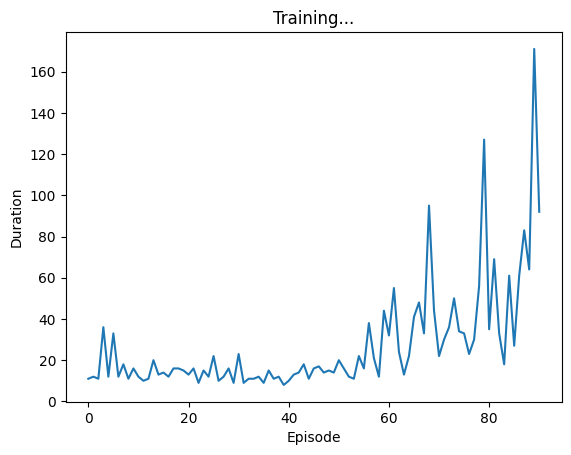

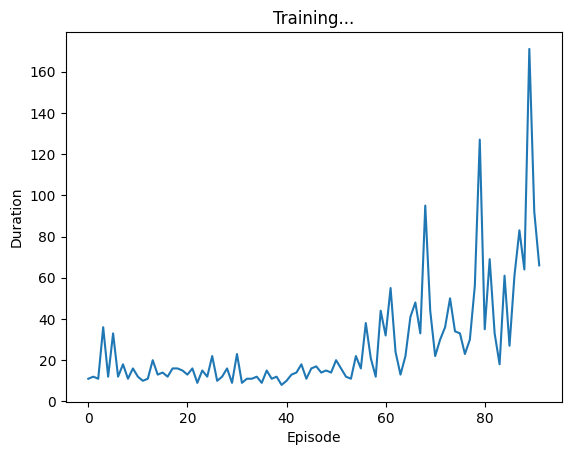

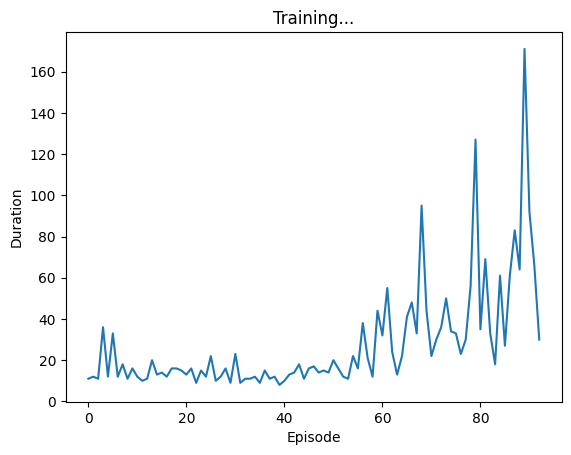

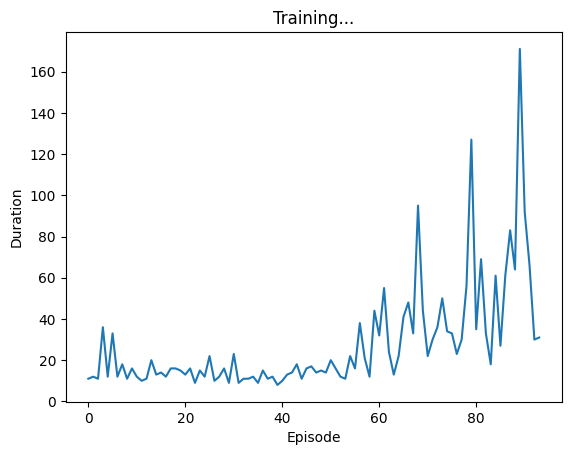

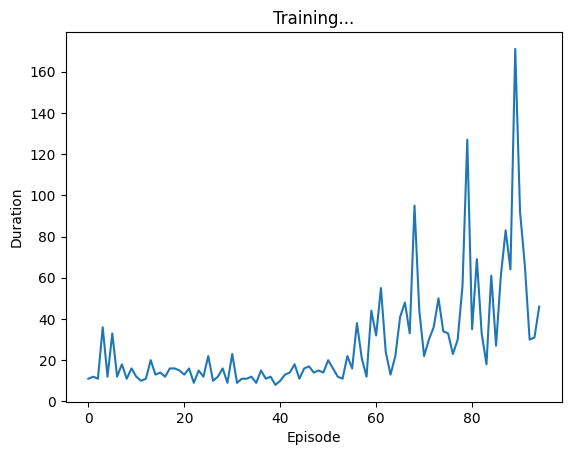

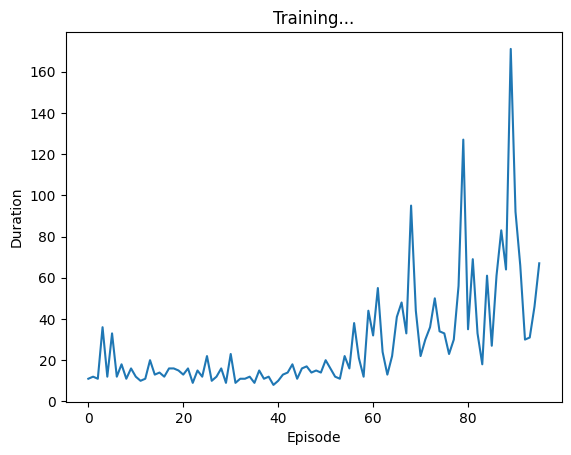

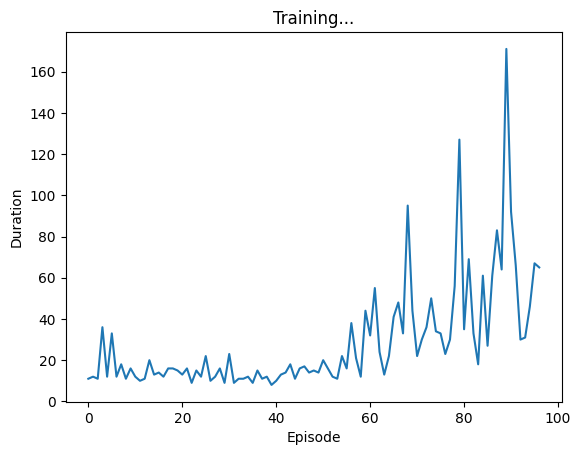

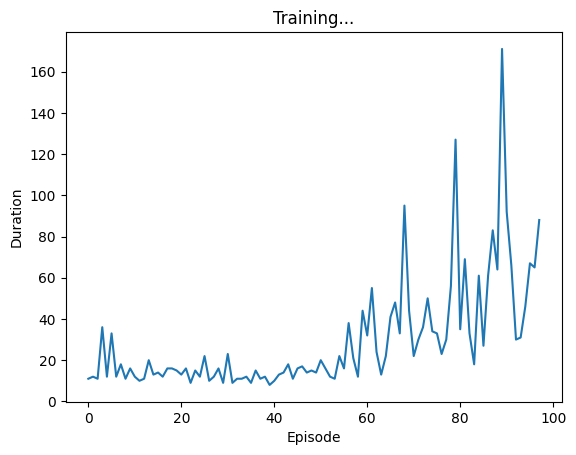

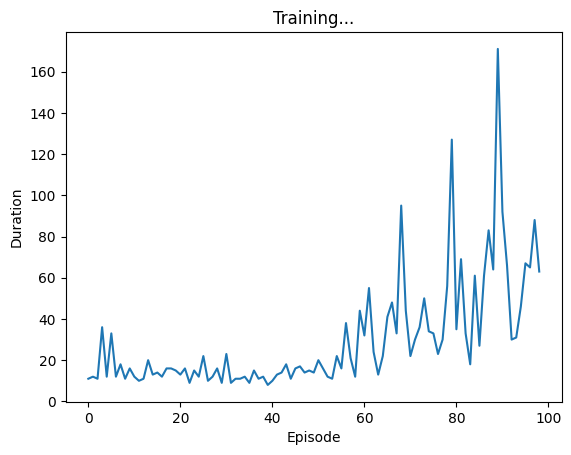

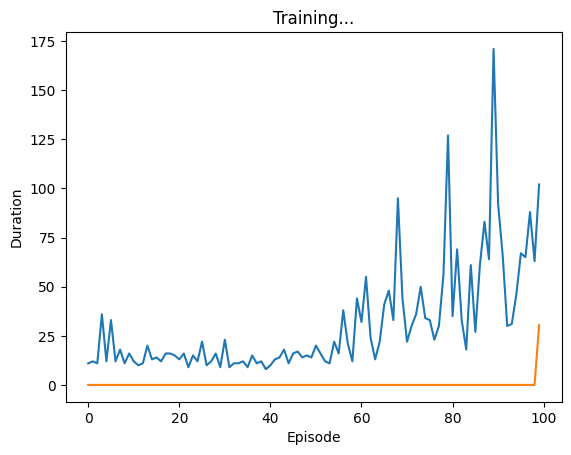

In [ ]:
actor = Actor(state_size, action_size).to(device)
critic = Critic(state_size, action_size).to(device)
trainIters(actor, critic, n_iters=100)